In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from environment import utils
from importlib import reload
reload(utils)
hedge_swaption, liab_swaption, _hedge_swap, liab_swap, liab_swaption_position, cov_hed_all, cov_liab_all, ttm_mat = utils.Utils().generate_swaption_market_data()
hedge_swap_ep = _hedge_swap[0]

# RL Agent Learning Diagnostics

This section provides visualizations and analysis to help monitor how well the critic is fitting the return distribution and other metrics to diagnose training issues.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import tensorflow as tf
import os
import glob
from pathlib import Path
import sys
import pandas as pd

time= '20250516_193854'
df = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_{time}/RL/Huber/spread=0.005_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/learner/logs.csv')
#df_eval = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250514_{time}/RL/Huber/spread=0.005_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv')
#time = '120609'
#df_old = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/learner/logs.csv')
df_train = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_{time}/RL/Huber/spread=0.005_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/train_loop/logs.csv'
                    )
#df_eval_old = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_20250509_{time}/RL/Huber/spread=0.05_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv'
#                    )
#

# Set Seaborn style for better visualizations
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
from time import sleep

def load_training_data(time=None, critic_type='qr-huber', spread=0.005, obj_func='cvar', 
                       threshold=0.95, vov=0.3, hedttm=30):
    """
    Load training data from logs folder based on run_id or time.
    
    Parameters:
    -----------
    run_id : str
        The run ID in format 'YYYYMMDD_HHMMSS'
    time : str
        Time component of the run ID if run_id is not provided
    
    Returns:
    --------
    dict : Dictionary with DataFrames for learner, train_loop, and eval_env
    """
    if time is None:
        # Get the most recent run folder
        run_folders = sorted(glob.glob('/home/hedge/gamma-vega-rl-hedging/logs/run_*'))
        if not run_folders:
            raise ValueError("No run folders found")
        run_path = run_folders[-1]
        run_id = os.path.basename(run_path).replace('run_', '')
    elif time is not None:
        # Use provided time component to construct run_id
        run_id = f"{time}"
    
    # Construct path to logs
    work_folder = f'spread={spread}_obj={obj_func}_threshold={threshold}_critic={critic_type}_v={vov}_hedttm={hedttm}'
    base_path = f'/home/hedge/gamma-vega-rl-hedging/logs/run_{run_id}/RL/Huber/{work_folder}'
    
    print(f"Loading data from: {base_path}")
    
    # Load data
    data = {}
    try:
        data['learner'] = pd.read_csv(f'{base_path}/logs/learner/logs.csv')
        print(f"Loaded learner data: {len(data['learner'])} rows")
    except FileNotFoundError:
        print("Learner logs not found")
    
    try:
        data['train_loop'] = pd.read_csv(f'{base_path}/logs/train_loop/logs.csv')
        print(f"Loaded train_loop data: {len(data['train_loop'])} rows")
    except FileNotFoundError:
        print("Train loop logs not found")
    
    try:
        data['eval_env'] = pd.read_csv(f'{base_path}/logs/eval_env/logs.csv')
        print(f"Loaded eval_env data: {len(data['eval_env'])} rows")
    except FileNotFoundError:
        print("Evaluation environment logs not found")
        
    return data, base_path

def plot_enhanced_loss_curves(learner_df, window_sizes=[50, 200, 500], clip_start=0):
    """
    Plot critic and policy loss curves with more detailed statistics and visualization.
    
    Parameters:
    -----------
    learner_df : DataFrame
        The learner log data
    window_sizes : list
        List of window sizes to use for different smoothing levels
    clip_start : int
        Number of initial data points to exclude
    """
    plt.figure(figsize=(15, 12))
    
    # Plot critic loss
    plt.subplot(2, 1, 1)
    raw_critic_loss = learner_df['critic_loss'].iloc[clip_start:]
    
    # Plot raw data with low opacity
    plt.plot(raw_critic_loss.index, raw_critic_loss, alpha=0.2, color='gray', linewidth=0.5, label='Raw Loss')
    
    # Plot smoothed lines with different window sizes
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(window_sizes)))
    
    for i, window in enumerate(window_sizes):
        mean_critic = raw_critic_loss.rolling(window=window).mean()
        std_critic = raw_critic_loss.rolling(window=window).std()
        
        plt.plot(mean_critic.index, mean_critic, color=colors[i], linewidth=2, 
                 label=f'Mean (window={window})')
        plt.fill_between(mean_critic.index, 
                        mean_critic - std_critic,
                        mean_critic + std_critic,
                        alpha=0.2, color=colors[i])
    
    # Add a trend line (linear regression)
    x = np.array(range(len(raw_critic_loss)))
    if len(x) > 1:  # Ensure we have enough data for regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, raw_critic_loss)
        trend_line = intercept + slope * x
        plt.plot(raw_critic_loss.index, trend_line, 'r--', 
                 label=f'Trend (slope={slope*(len(learner_df)-clip_start):.6f}, R²={r_value**2:.3f})')
    
    plt.title('Critic Loss Over Training Steps', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Add statistics as text
    stats_text = (
        f"Min: {raw_critic_loss.min():.6f}\n"
        f"Max: {raw_critic_loss.max():.6f}\n"
        f"Mean: {raw_critic_loss.mean():.6f}\n"
        f"Std Dev: {raw_critic_loss.std():.6f}\n"
        f"Latest: {raw_critic_loss.iloc[-1]:.6f}"
    )
    plt.text(0.02, 0.95, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.7), fontsize=10, va='top')
    
    # Plot policy loss with same approach
    plt.subplot(2, 1, 2)
    raw_policy_loss = learner_df['policy_loss'].iloc[clip_start:]
    
    plt.plot(raw_policy_loss.index, raw_policy_loss, alpha=0.2, color='gray', linewidth=0.5, label='Raw Loss')
    
    for i, window in enumerate(window_sizes):
        mean_policy = raw_policy_loss.rolling(window=window).mean()
        std_policy = raw_policy_loss.rolling(window=window).std()
        
        plt.plot(mean_policy.index, mean_policy, color=colors[i], linewidth=2, 
                 label=f'Mean (window={window})')
        plt.fill_between(mean_policy.index, 
                        mean_policy - std_policy,
                        mean_policy + std_policy,
                        alpha=0.2, color=colors[i])
    
    # Add a trend line for policy loss
    if len(x) > 1:  # Ensure we have enough data for regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, raw_policy_loss)
        trend_line = intercept + slope * x
        plt.plot(raw_policy_loss.index, trend_line, 'r--', 
                 label=f'Trend (slope={slope*(len(learner_df)-clip_start):.8f}, R²={r_value**2:.3f})')
    
    plt.title('Policy Loss Over Training Steps', fontsize=14)
    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Add statistics for policy loss
    stats_text = (
        f"Min: {raw_policy_loss.min():.8f}\n"
        f"Max: {raw_policy_loss.max():.8f}\n"
        f"Mean: {raw_policy_loss.mean():.8f}\n"
        f"Std Dev: {raw_policy_loss.std():.8f}\n"
        f"Latest: {raw_policy_loss.iloc[-1]:.8f}"
    )
    plt.text(0.02, 0.95, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.7), fontsize=10, va='top')
    
    plt.tight_layout()
    plt.show()

def plot_training_episode_returns(train_df, window_sizes=[20, 100, 200]):
    """
    Plot episode returns with detailed statistical analysis.
    
    Parameters:
    -----------
    train_df : DataFrame
        The training loop data
    window_sizes : list
        List of window sizes for different smoothing levels
    """
    if 'episode_return' not in train_df.columns:
        print("Episode return data not found in training data")
        return
    
    plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])
    
    # Main plot of episode returns
    ax1 = plt.subplot(gs[0, :])
    
    returns = train_df['episode_return']
    episodes = train_df['episodes']
    
    # Plot individual returns as scatter points
    ax1.scatter(episodes, returns, alpha=0.3, s=10, color='gray', label='Individual Episodes')
    
    # Plot smoothed returns with different window sizes
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(window_sizes)))
    
    for i, window in enumerate(window_sizes):
        mean_returns = returns.rolling(window=window).mean()
        std_returns = returns.rolling(window=window).std()
        
        ax1.plot(episodes, mean_returns, linewidth=2, color=colors[i], 
                 label=f'Mean (window={window})')
        ax1.fill_between(episodes, 
                        mean_returns - std_returns,
                        mean_returns + std_returns,
                        alpha=0.2, color=colors[i])
    
    # Add CVaR 95% line
    if len(returns) >= 400:  # Only calculate if we have enough data
        cvar_window = 500
        def cvar(x, alpha=0.05):
            var = np.quantile(x, alpha)
            return x[x <= var].mean()
        cvar95 = returns.rolling(window=cvar_window).apply(lambda x: cvar(x))
        ax1.plot(episodes, cvar95, color='red', linestyle='--', 
                 label=f'CVaR 95% (window={cvar_window})')
    
    ax1.set_title('Episode Returns During Training', fontsize=14)
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Return', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Add a text box with statistics
    latest_window = min(100, len(returns))
    recent_returns = returns.iloc[-latest_window:]
    
    stats_text = (
        f"Overall Statistics:\n"
        f"  Mean: {returns.mean():.4f}\n"
        f"  Std Dev: {returns.std():.4f}\n"
        f"  Min: {returns.min():.4f}\n"
        f"  Max: {returns.max():.4f}\n\n"
        f"Last {latest_window} Episodes:\n"
        f"  Mean: {recent_returns.mean():.4f}\n"
        f"  Std Dev: {recent_returns.std():.4f}\n"
        f"  CVaR 95%: {np.percentile(recent_returns, 5):.4f}"
    )
    
    ax1.text(0.02, 0.97, stats_text, transform=ax1.transAxes, 
             bbox=dict(facecolor='white', alpha=0.7), fontsize=10, va='top')
    
    # Histogram of returns
    ax2 = plt.subplot(gs[1, 0])
    sns.histplot(returns, kde=True, ax=ax2)
    ax2.axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.4f}')
    ax2.axvline(recent_returns.mean(), color='blue', linestyle='--', label=f'Mean (recent returns): {recent_returns.mean():.4f}')

    ax2.axvline(np.percentile(returns, 5), color='green', linestyle='--', 
                label=f'5th Percentile: {np.percentile(returns, 5):.4f}')
    ax2.axvline(np.percentile(recent_returns, 5), color='black', linestyle='--', 
                label=f'5th Percentile (recent returns): {np.percentile(recent_returns, 5):.4f}')
    ax2.set_title('Distribution of Episode Returns', fontsize=12)
    ax2.legend(fontsize=10)
    
    # QQ plot to check for normality
    ax3 = plt.subplot(gs[1, 1])
    stats.probplot(returns, plot=ax3)
    ax3.set_title('QQ Plot of Episode Returns', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Return key statistics
    return {
        'mean': returns.mean(),
        'std': returns.std(),
        'min': returns.min(),
        'max': returns.max(),
        'median': returns.median(),
        'cvar95': np.percentile(returns, 5),
        'latest_mean': recent_returns.mean(),
        'latest_std': recent_returns.std()
    }

data, base_path = load_training_data(time=time)
# Plot enhanced loss curves if learner data is available
if 'learner' in data and len(data['learner']) > 0:
    # Determine appropriate clip value - typically early training is noisy
    total_steps = len(data['learner'])
    clip_start = max(int(total_steps * 0.05),25_000)  # Skip first 5% or 2500 steps, whichever is smaller
    
    print(f"Plotting loss curves with initial {clip_start} steps clipped")
    plot_enhanced_loss_curves(data['learner'], clip_start=clip_start)
else:
    print("Learner data not available for loss curve analysis")


# Plot training episode returns if data is available
if 'train_loop' in data and len(data['train_loop']) > 0:
    statss = plot_training_episode_returns(data['train_loop'])
    print("\nEpisode Return Statistics:")
    for key, value in statss.items():
        print(f"  {key}: {value:.6f}")
else: 
    print("Training loop data not available for episode return analysis")

In [ ]:
df_eval = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/run_{time}/RL/Huber/spread=0.005_obj=cvar_threshold=0.95_critic=qr-huber_v=0.3_hedttm=30/logs/eval_env/logs.csv')

In [ ]:
def analyze_action_vs_state(eval_env_df):
    """
    Analyze how actions relate to state variables.
    
    Parameters:
    -----------
    eval_env_df : DataFrame
        The evaluation environment log data
    """
    if eval_env_df is None or len(eval_env_df) == 0:
        print("No evaluation environment data available")
        return
    eval_env_df['total_vol'] = (eval_env_df['iv_norm']*0.11112382868869143+0.43473235958601) * (eval_env_df['rate_norm']*0.021853509133030684+0.049410736630389)
    eval_env_df['cost_ratio'] = eval_env_df['gamma_ratio'] / eval_env_df['hed_cost_norm'] * eval_env_df['iv_norm'] * eval_env_df['rate_norm']
    eval_env_df['gamma_cost'] = eval_env_df['cost_ratio'] * eval_env_df['gamma_unit_norm'] * eval_env_df['iv_norm'] * eval_env_df['rate_norm']
    # Identify relevant state variables
    state_vars = [col for col in eval_env_df.columns if col in 
                 ['gamma_ratio', 'iv_norm', 'rate_norm', 'hed_cost_norm', 'ttm', 'gamma_unit_norm', 'gamma_port_sign', 'cost_ratio', 'gamma_cost','total_vol']]

    if not state_vars:
        print("No relevant state variables found in evaluation data")
        return
    
    # Create a figure with subplots for each state variable
    n_vars = len(state_vars)
    fig, axes = plt.subplots(1, n_vars, figsize=(15, 5))
    
    if n_vars == 1:  # Make axes iterable if there's only one subplot
        axes = [axes] # & (eval_env_df['gamma_ratio']<0.2) & (np.abs(eval_env_df['cost_ratio']) < 10)& (eval_env_df['cost_ratio'] > 0)& (eval_env_df['gamma_cost'] > 0) 
    eval_env_df = eval_env_df[(eval_env_df['ttm']>=1) & (eval_env_df['ttm']<1.05) & ((eval_env_df['iv_norm']*0.11112382868869143+0.43473235958601) * (eval_env_df['rate_norm']*0.021853509133030684+0.049410736630389) > 0.015) & (eval_env_df['gamma_ratio']>0.01)& (eval_env_df['gamma_ratio']<0.02)]
    # Plot action vs each state variable
    for i, var in enumerate(state_vars):
        axes[i].scatter(eval_env_df[var], eval_env_df['action_gamma'], alpha=0.1)
        axes[i].set_title(f'Action vs {var}', fontsize=12)
        axes[i].set_xlabel(var, fontsize=10)
        axes[i].set_ylabel('action_gamma', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        
        # Try to fit a regression line if enough points
        if len(eval_env_df) > 10:
            try:
                from scipy.stats import linregress
                mask = ~np.isnan(eval_env_df[var]) & ~np.isnan(eval_env_df['action_gamma'])
                if sum(mask) > 10:  # Only fit if we have enough valid data points
                    x = eval_env_df[var][mask]
                    y = eval_env_df['action_gamma'][mask]
                    slope, intercept, r_value, p_value, std_err = linregress(x, y)
                    
                    # Plot regression line
                    x_range = np.linspace(x.min(), x.max(), 100)
                    axes[i].plot(x_range, intercept + slope*x_range, 'r', 
                                label=f'R²={r_value**2:.3f}')
                    axes[i].legend(loc='best', fontsize=8)
            except Exception as e:
                print(f"Could not fit regression for {var}: {e}")
    
    plt.tight_layout()
    plt.show()
    
    # Create more detailed analysis of the most important relationship
    # Let's find which state variable has the highest correlation with actions
    correlations = {}
    for var in state_vars:
        mask = ~np.isnan(eval_env_df[var]) & ~np.isnan(eval_env_df['action_gamma'])
        if sum(mask) > 10:
            correlations[var] = eval_env_df[var][mask].corr(eval_env_df['action_gamma'][mask])
    
    if correlations:
        # Sort by absolute correlation value
        sorted_corrs = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
        print("\nCorrelations between state variables and actions:")
        for var, corr in sorted_corrs:
            print(f"  {var}: {corr:.4f}")
        
        # Plot the most correlated variable in more detail
        best_var = sorted_corrs[0][0]
        
        plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
        
        # Scatter plot with colored points by episode
        ax1 = plt.subplot(gs[0])
        
        # Select a limited number of episodes to show with different colors
        episodes = eval_env_df['episode'].unique()
        selected_episodes = episodes[:min(10, len(episodes))]  # Select up to 10 episodes
        
        for ep in selected_episodes:
            ep_data = eval_env_df[eval_env_df['episode'] == ep]
            ax1.scatter(ep_data[best_var], ep_data['action_gamma'], alpha=0.7, label=f'Episode {ep}')
        
        # Add trend line for all data
        mask = ~np.isnan(eval_env_df[best_var]) & ~np.isnan(eval_env_df['action_gamma'])
        if sum(mask) > 10:
            x = eval_env_df[best_var][mask]
            y = eval_env_df['action_gamma'][mask]
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            
            x_range = np.linspace(x.min(), x.max(), 100)
            ax1.plot(x_range, intercept + slope*x_range, 'r--', linewidth=2,
                    label=f'Trend: y = {slope:.4f}x + {intercept:.4f}, R²={r_value**2:.4f}')
        
        ax1.set_title(f'Action vs {best_var} (by episode)', fontsize=14)
        ax1.set_xlabel(best_var, fontsize=12)
        ax1.set_ylabel('action_gamma', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='best', fontsize=8)
        
        # Histogram of the best variable
        ax2 = plt.subplot(gs[1])
        sns.histplot(eval_env_df[best_var], kde=True, ax=ax2)
        ax2.set_title(f'Distribution of {best_var}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
    
# Analyze actions vs state variables if evaluation data is available
if 'eval_env' in data and len(data['eval_env']) > 0:
    analyze_action_vs_state(data['eval_env'])
else:
    print("Evaluation environment data not available for action analysis")

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import shap

# 1. Load your data
# df has columns ['x1','x2',…,'x7','y']
X = data['eval_env'][['gamma_ratio', 'iv_norm', 'rate_norm', 'hed_cost_norm', 'ttm', 'gamma_unit_norm']]
y = data['eval_env']['action_gamma']

# 2. Fit a shallow tree‐based surrogate
sur = RandomForestRegressor(n_estimators=200, max_depth=4, random_state=0)
sur.fit(X, y)

# 3. Use SHAP’s TreeExplainer for interaction values
explainer = shap.TreeExplainer(sur)
# This returns an array of shape (n_samples, 7, 7)
shap_int = explainer.shap_interaction_values(X)

# 4. Compute mean absolute interaction strengths
mean_int = np.mean(np.abs(shap_int), axis=0)
# zero out the diagonals (self‐effects)
np.fill_diagonal(mean_int, 0)

# 5. List the top interacting pairs
pairs = [
    (X.columns[i], X.columns[j], mean_int[i, j])
    for i in range(7) for j in range(i+1, 6)
]
top5 = sorted(pairs, key=lambda x: -x[2])[:5]
print("Top 5 interactions:", top5)

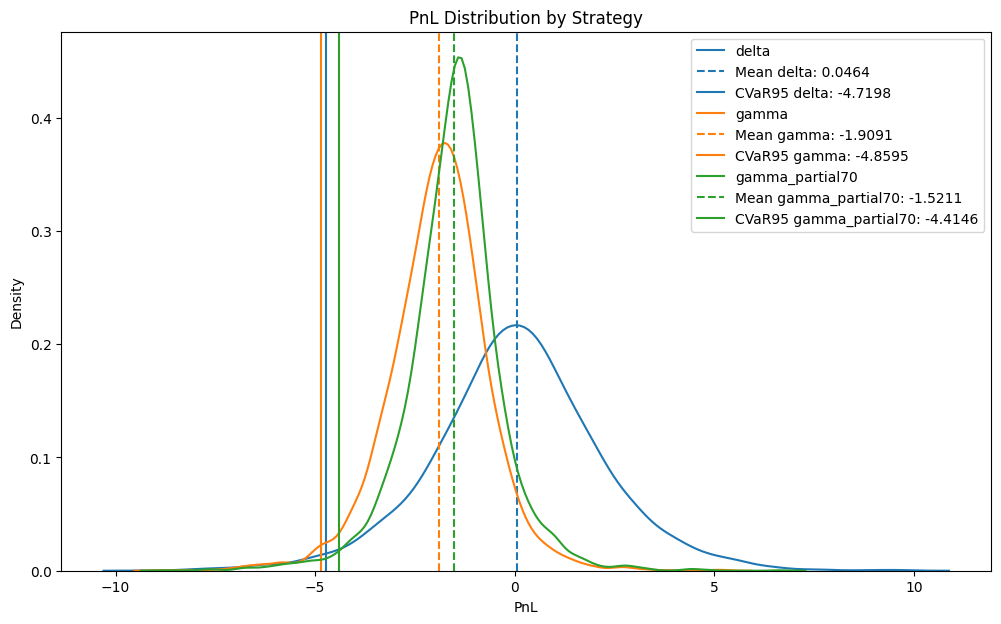

{'delta': {'mean': 0.04635488056264623,
  'std': 2.132635184954816,
  'quantile_05': -3.4470359498272,
  'min': -9.1308766203,
  'max': 9.7072633745},
 'gamma': {'mean': -1.9090690636188294,
  'std': 1.258325591905209,
  'quantile_05': -3.958915412832,
  'min': -8.8309435572,
  'max': 5.2503446158000004},
 'gamma_partial70': {'mean': -1.5211097981895465,
  'std': 1.1988783947960628,
  'quantile_05': -3.43568675675,
  'min': -8.711287098,
  'max': 6.6278088770000005}}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_pnl_distribution(dataframes, labels=None, xlim=None, legend_prefix=""):
    """
    Plot KDE distributions of PnL for multiple dataframes.
    
    Parameters:
    -----------
    dataframes : dict or list
        If dict: {name: dataframe} pairs
        If list: List of dataframes
    labels : list, optional
        Labels for each dataframe (used if dataframes is a list)
    xlim : tuple, optional
        x-axis limits (min, max)
    legend_prefix : str, optional
        Prefix to add to legend entries
    """
    plt.figure(figsize=(12, 7))
    
    # Convert list to dict if needed
    if isinstance(dataframes, list):
        if labels is None:
            labels = [f"Dataset {i+1}" for i in range(len(dataframes))]
        dataframes = dict(zip(labels, dataframes))
    
    # Process each dataframe
    colors = sns.color_palette()
    for i, (name, df) in enumerate(dataframes.items()):
        # Calculate PnL sum per episode
        pnl_sum = df.groupby('episode')['step_pnl'].sum()
        
        # Plot KDE
        sns.kdeplot(pnl_sum, label=f"{name}")
        
        # Add vertical line for mean
        mean_val = pnl_sum.mean()
        plt.axvline(mean_val, color=colors[i], linestyle='--',
                   label=f'Mean {name}: {mean_val:.4f}')
        alpha = 0.05
        var95 = pnl_sum.quantile(alpha)
        cvar95 = pnl_sum[pnl_sum <= var95].mean()
        
        # Add vertical line for 0.05 quantile (CVaR 95%)
        #quantile_val = pnl_sum.quantile(0.05)
        plt.axvline(cvar95, color=colors[i], linestyle='-',
                   label=f'CVaR95 {name}: {cvar95:.4f}')
        
    
    # Add plot details
    plt.title('PnL Distribution by Strategy')
    plt.xlabel('PnL')
    plt.ylabel('Density')
    
    if xlim:
        plt.xlim(xlim)
    
    #plt.grid(True)
    plt.legend()
    plt.show()
    
    # Return summary statistics
    results = {}
    for name, df in dataframes.items():
        pnl_sum = df.groupby('episode')['step_pnl'].sum()
        results[name] = {
            'mean': pnl_sum.mean(),
            'std': pnl_sum.std(),
            'quantile_05': pnl_sum.quantile(0.05),
            'min': pnl_sum.min(),
            'max': pnl_sum.max()
        }
    return results


def load_df(name, spread, dataset):
    df = pd.read_csv(f'/home/hedge/gamma-vega-rl-hedging/logs/greek_baseline/{name}/{dataset}/{spread}/run_/logs/eval_env/logs.csv'
                           )
    return df
spread = 0.015
dataset = 'stress'
names = ['delta', 'gamma','gamma_partial70',]

#df_list.append(df_eval)
#names.append('RL')
for spread in [0.005,0.01,0.015,0.02]
df_list = [load_df(name,spread, 'calm_flat_5pct_curve') for name in names]
plot_pnl_distribution(df_list, names, xlim=None)

In [ ]:
import numpy as np
print(np.mean(df_eval.groupby('episode').aggregate('sum')['cost_swaption_hed']))
print(np.mean(df_gamma_spread5.groupby('episode').aggregate('sum')['cost_swaption_hed']))

In [ ]:
np.mean(df_eval.groupby('episode').quantile(0.05)['step_pnl'])
print(np.mean(df_gamma_partial50.groupby('episode').quantile(0.05)['step_pnl'])-np.mean(df_gamma_spread5.groupby('episode').quantile(0.05)['step_pnl']))
np.mean(df_gamma_spread5.groupby('episode').quantile(0.05)['step_pnl'])

In [ ]:
np.mean(df_eval_old.groupby('episode').quantile(0.05)['step_pnl'])

In [ ]:
df_gamma_partial50.groupby('episode').aggregate('sum')['step_pnl'].mean()*100-df_gamma_spread5.groupby('episode').aggregate('sum')['step_pnl'].mean()*100

In [ ]:
import os
import tensorflow as tf
import sonnet as snt
import numpy as np
import sys
from gym import spaces
from acme import specs
from acme import wrappers
# Add project root to path to import modules
sys.path.append('/home/hedge/gamma-vega-rl-hedging')

from acme import specs
from environment.Environment import TradingEnv
from environment.utils import Utils
from run import make_quantile_networks, make_networks, make_iqn_networks

def load_policy_as_function(run_id=None, 
                            agent_path=None,
                            critic_type='qr-huber',
                            spread=0.005,
                            obj_func='cvar',
                            threshold=0.95,
                            vov=0.3,
                            hed_ttm=30):
    """
    Load a trained policy network and return it as a simple function that maps observations to actions
    
    Returns:
        A function that takes an observation array and returns an action
    """
    # Construct work folder if not provided
    work_folder = f'spread={spread}_obj={obj_func}_threshold={threshold}_critic={critic_type}_v={vov}_hedttm={hed_ttm}'
    
    # Construct agent path if not provided
    if agent_path is None and run_id is not None:
        agent_path = f'./logs/run_{run_id}/RL/Huber/{work_folder}'
    elif agent_path is None:
        raise ValueError("Either run_id or agent_path must be provided")
        
    print(f"Loading policy from: {agent_path}")
    
    # Set up a minimal environment to get the spec
    action_space = specs.BoundedArray((1,), np.float32, 0,1)

    agent_networks = make_quantile_networks(action_spec=action_space, policy_layer_sizes=(256,256,256))

    
    # Get the policy and observation networks
    policy_net = agent_networks['policy']
    observation_net = agent_networks['observation']
    
    # Initialize with a dummy pass
    dummy_obs = tf.zeros([1, 7], dtype=tf.float32)
    processed_obs = observation_net(dummy_obs)
    _ = policy_net(processed_obs)
    
    # Load the policy network weights
    try:
        trainable_variables_snapshot = {}
        load_policy_net = tf.saved_model.load(f"{agent_path}/policy")
        
        print(f"Loading policy network with {len(load_policy_net.trainable_variables)} variables")
        print(f"Target policy network has {len(policy_net.trainable_variables)} variables")
        
        for var in load_policy_net.trainable_variables:
            var_name = '/'.join(var.name.split('/')[1:])
            trainable_variables_snapshot[var_name] = var.numpy()
            
        for var in policy_net.trainable_variables:
            var_name_wo_name_scope = '/'.join(var.name.split('/')[1:])
            if var_name_wo_name_scope in trainable_variables_snapshot:
                var.assign(trainable_variables_snapshot[var_name_wo_name_scope])
            else:
                print(f"WARNING: Variable {var_name_wo_name_scope} not found in saved model")
    except Exception as e:
        print(f"Error loading policy: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    # Create a simple function that applies both networks
    def policy_function(observation):
        """Takes an observation array and returns an action"""
        # Convert to tensor if needed
        if not isinstance(observation, tf.Tensor):
            observation = tf.convert_to_tensor(observation, dtype=tf.float32)
        
        # Reshape if needed (ensure batch dimension)
        if len(observation.shape) == 1:
            observation = tf.expand_dims(observation, 0)
            
        # Apply the observation and policy networks
        processed_obs = observation_net(observation)
        action = policy_net(processed_obs)
        
        # Return as numpy array
        return action.numpy()
    
    print("Policy function successfully loaded and ready to use")
    return policy_function

# Example usage:
# policy_fn = load_policy_as_function(run_id='20250513_001629')
# action = policy_fn(observation)  # observation is a numpy array or tensor


In [ ]:
policy_fn = load_policy_as_function(run_id='20250514_181957')

In [ ]:
import matplotlib.pyplot as plt
action_list = []
for i in np.linspace(-1,1,10):
    action_list.append(policy_fn([0,0,i,0,1,1,1])[0])
plt.plot(np.linspace(-1,1,10),action_list)

plt.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# fixed parts of state: [s0, s1, s2, s3, s4, s5, s6]
base_state = np.array([0, 0, 0, 0, 0, 0, 0])

# choose the two indices you’ll sweep over
i_idx, j_idx = 2, 5

# define your 7×7 grid for those two dims
i_vals = np.linspace(-1, 1, 20)
j_vals = np.linspace(-1, 1, 20)
I, J = np.meshgrid(i_vals, j_vals, indexing='xy')

# evaluate policy at each grid point
Z = np.zeros_like(I, dtype=float)  # or int, depending on your policy
for row in range(I.shape[0]):
    for col in range(I.shape[1]):
        s = base_state.copy()
        s[i_idx] = I[row, col]
        s[j_idx] = J[row, col]
        action = policy_fn(s)[0]
        Z[row, col] = action  # if stochastic, pick Z[row,col]=P(a|s) or entropy etc.

# now plot
plt.figure(figsize=(6,5))
# for discrete actions use pcolormesh with a discrete colormap:
c = plt.pcolormesh(I, J, Z, cmap='viridis')
plt.colorbar(c, ticks=np.unique(Z), label='action π(s)')

# if you instead have a continuous action, or want smooth contours:
# plt.contourf(I, J, Z, levels=20)
# plt.colorbar(label='action value')

plt.xlabel(f'state[{i_idx}]')
plt.ylabel(f'state[{j_idx}]')
plt.title('Policy Heatmap over two state dimensions')
plt.grid(True)
plt.show()


In [ ]:
action_gamma = results_single['action_gamma']
iv = results_single.iv_norm
gamma = results_single.gamma_ratio
plt.scatter(gamma,action_gamma)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

# Add project root to path to import modules if needed
sys.path.append('/home/hedge/gamma-vega-rl-hedging')

from acme import specs
from acme.tf import utils as tf2_utils
from run import make_quantile_networks, make_iqn_networks, make_networks, load_agent
from environment.utils import Utils
from environment.Environment import TradingEnv

# Set visual style
#plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

In [ ]:
def load_critic_network(run_id=None, time=None, critic_type='qr-huber', spread=0.005, 
                       obj_func='cvar', threshold=0.95, vov=0.3, hedttm=30):
    """
    Load the critic network from a trained model.
    
    Parameters:
    -----------
    run_id : str
        The run ID in format 'YYYYMMDD_HHMMSS'
    time : str
        Time component of the run ID if run_id is not provided
        
    Returns:
    --------
    critic_network : tf.Module
        The loaded critic network
    observation_network : tf.Module
        The loaded observation network
    environment_spec : acme.specs.EnvironmentSpec
        The environment specification
    """
    if run_id is None and time is None:
        # Get the most recent run
        raise ValueError("Either run_id or time must be provided")
    elif time is not None:
        # Use provided time component to construct run_id
        date_part = run_id.split('_')[0] if run_id else '20250514'
        run_id = f"{date_part}_{time}"
    
    # Construct path to logs
    work_folder = f'spread={spread}_obj={obj_func}_threshold={threshold}_critic={critic_type}_v={vov}_hedttm={hedttm}'
    base_path = f'/home/hedge/gamma-vega-rl-hedging/logs/run_{run_id}/RL/Huber/{work_folder}'
    
    print(f"Loading model from: {base_path}")
    
    # Create a dummy environment to get the specs
    utils = Utils(n_episodes=1000, tenor=4, spread=spread)
    environment_spec = specs.make_environment_spec(TradingEnv(utils=utils))
    
    # Create networks based on critic type
    if critic_type == 'c51':
        agent_networks = make_networks(action_spec=environment_spec.actions, max_time_steps=utils.num_period)
    elif 'qr' in critic_type:
        agent_networks = make_quantile_networks(action_spec=environment_spec.actions)
    elif critic_type == 'iqn':
        agent_networks = make_iqn_networks(action_spec=environment_spec.actions, cvar_th=threshold, max_time_steps=62)
    else:
        raise ValueError(f"Unknown critic type: {critic_type}")
    
    # Get critic and observation networks
    critic_network = agent_networks['critic']
    observation_network = agent_networks['observation']
    
    # Initialize network variables with a dummy pass
    dummy_obs = tf.zeros([1, environment_spec.observations.shape[0]], dtype=tf.float32)
    dummy_action = tf.zeros([1, environment_spec.actions.shape[0]], dtype=tf.float32)
    
    # First process the observation
    processed_obs = observation_network(dummy_obs)
    
    # Then pass to critic
    _ = critic_network(processed_obs, dummy_action)
    
    # Now load the trained weights
    try:
        load_agent(None, observation_network, base_path)
        print("Observation network loaded successfully")
        
        # For critic, we need to extract it from the snapshot
        snapshot = tf.saved_model.load(f"{base_path}/critic")
        
        # Copy weights from snapshot to our critic network
        for var, loaded_var in zip(critic_network.variables, snapshot.variables):
            var.assign(loaded_var)
        
        print("Critic network loaded successfully")
    except Exception as e:
        print(f"Error loading networks: {e}")
        # This error is expected if we don't have the critic saved separately
        print("Will proceed with initialized networks which may not have trained weights")
    
    return critic_network, observation_network, environment_spec, base_path

In [ ]:
def collect_episode_trajectories(base_path):
    """
    Collect evaluation episode trajectories from logs.
    
    Parameters:
    -----------
    base_path : str
        Base path to the model directory
        
    Returns:
    --------
    df : pd.DataFrame
        DataFrame with episode trajectories
    """
    try:
        eval_path = f"{base_path}/logs/eval_env/logs.csv"
        df = pd.read_csv(eval_path)
        print(f"Loaded evaluation data: {len(df)} rows from {len(df['episode'].unique())} episodes")
        return df
    except Exception as e:
        print(f"Error loading evaluation data: {e}")
        print("Will attempt to use training data instead")
        
        try:
            train_path = f"{base_path}/logs/train_loop/logs.csv"
            df = pd.read_csv(train_path)
            print(f"Loaded training data: {len(df)} rows")
            return df
        except Exception as e2:
            print(f"Error loading training data: {e2}")
            return None

In [ ]:
# Load the model using the time variable from previous cells
try:
    critic_network, observation_network, environment_spec, base_path = load_critic_network(time=time)
    trajectories_df = collect_episode_trajectories(base_path)
except Exception as e:
    print(f"Failed to load model: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
def extract_quantiles_from_critic(critic_network, observation_network, states, actions):
    """
    Extract predicted quantiles from the critic network.
    
    Parameters:
    -----------
    critic_network : tf.Module
        The critic network
    observation_network : tf.Module
        The observation processing network
    states : np.ndarray
        Batch of states
    actions : np.ndarray
        Batch of actions
        
    Returns:
    --------
    quantiles : np.ndarray
        Predicted quantiles (batch_size, n_quantiles)
    """
    # Convert inputs to tensors
    states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
    actions_tensor = tf.convert_to_tensor(actions, dtype=tf.float32)
    
    # Process observations
    processed_obs = observation_network(states_tensor)
    
    # Get critic output
    critic_output = critic_network(processed_obs, actions_tensor)
    
    # For QR-DQN, the output should be the quantile values
    # The exact format depends on the implementation
    
    # Check if critic output has a logits attribute (C51 distributional critic)
    if hasattr(critic_output, 'logits'):
        # For C51, we have logits that need to be converted to probabilities
        probs = tf.nn.softmax(critic_output.logits, axis=-1)
        # Get the support values
        atoms = critic_output.atoms
        # Calculate the expected value
        expected_value = tf.reduce_sum(probs * atoms, axis=-1)
        # For visualization purposes, let's create synthetic quantiles from the distribution
        # This is a simple approach - for a proper implementation, you'd calculate the actual quantiles
        cum_probs = tf.cumsum(probs, axis=-1)
        quantile_indices = []
        quantiles = np.linspace(0.05, 0.95, 10)  # 10 quantiles
        for q in quantiles:
            idx = tf.argmax((cum_probs > q).astype(tf.float32), axis=-1)
            quantile_indices.append(idx)
        quantile_indices = tf.stack(quantile_indices, axis=-1)
        batch_indices = tf.range(tf.shape(quantile_indices)[0])
        batch_indices = tf.tile(tf.expand_dims(batch_indices, -1), [1, tf.shape(quantile_indices)[1]])
        indices = tf.stack([batch_indices, quantile_indices], axis=-1)
        quantile_values = tf.gather_nd(atoms, indices)
        return quantile_values.numpy(), expected_value.numpy()
    
    # For QR-DQN, we directly have the quantile values
    elif hasattr(critic_output, 'values'):
        # Return the quantile values and their mean
        expected_value = tf.reduce_mean(critic_output.values, axis=-1)
        return critic_output.values.numpy(), expected_value.numpy()
    
    # In case the structure is different, try a generic approach
    else:
        try:
            # Assume the first attribute is the distribution
            first_attr = list(critic_output.__dict__.keys())[0]
            values = getattr(critic_output, first_attr)
            if isinstance(values, tf.Tensor):
                expected_value = tf.reduce_mean(values, axis=-1)
                return values.numpy(), expected_value.numpy()
            else:
                print(f"Unexpected critic output structure: {type(critic_output)}")
                return None, None
        except:
            print(f"Failed to extract quantiles from critic output: {type(critic_output)}")
            return None, None

In [ ]:
def visualize_critic_predictions(critic_network, observation_network, trajectories_df, 
                                n_episodes=5, samples_per_episode=10):
    """
    Visualize how well the critic predicts the actual return distribution.
    
    Parameters:
    -----------
    critic_network : tf.Module
        The critic network
    observation_network : tf.Module
        The observation processing network
    trajectories_df : pd.DataFrame
        DataFrame with episode trajectories
    n_episodes : int, optional
        Number of episodes to visualize
    samples_per_episode : int, optional
        Number of samples per episode to visualize
    """
    if trajectories_df is None or len(trajectories_df) == 0:
        print("No trajectory data available")
        return
    
    # Get a list of unique episodes
    unique_episodes = trajectories_df['episode'].unique()
    if len(unique_episodes) < n_episodes:
        n_episodes = len(unique_episodes)
    
    # Select episodes to visualize
    selected_episodes = np.sort(np.random.choice(unique_episodes, size=n_episodes, replace=False))
    
    plt.figure(figsize=(16, n_episodes * 4))
    
    for i, episode in enumerate(selected_episodes):
        # Get data for this episode
        episode_data = trajectories_df[trajectories_df['episode'] == episode].copy()
        
        # Skip episodes without enough time steps
        if len(episode_data) < 10:
            continue
        
        # We'll sample state-action pairs from different time points in the episode
        if len(episode_data) <= samples_per_episode:
            sampled_indices = np.arange(len(episode_data))
        else:
            sampled_indices = np.sort(np.random.choice(
                np.arange(len(episode_data)), 
                size=samples_per_episode, 
                replace=False
            ))
        
        sampled_data = episode_data.iloc[sampled_indices].copy()
        
        # Extract states and actions
        states = sampled_data[['rate_norm', 'hed_cost_norm', 'gamma_ratio', 
                               'gamma_unit_norm', 'iv_norm', 'ttm']].values
        actions = sampled_data[['action_gamma']].values
        
        # Get critic predictions
        quantiles, expected_values = extract_quantiles_from_critic(
            critic_network, observation_network, states, actions
        )
        
        if quantiles is None:
            print("Failed to extract quantiles from critic")
            continue
        
        # Calculate the actual returns from this point onwards for each sampled step
        actual_returns = []
        for idx in sampled_indices:
            future_rewards = episode_data.iloc[idx:]['step_pnl'].values
            # Apply discounting
            discounted_return = 0
            discount = 0.98  # Use the same discount factor as in training
            for t, reward in enumerate(future_rewards):
                discounted_return += discount**t * reward
            actual_returns.append(discounted_return)
        
        # Create subplots for this episode
        plt.subplot(n_episodes, 2, i*2 + 1)
        
        # Plot predicted quantiles vs actual returns
        for j in range(len(sampled_indices)):
            # Plot predicted quantiles as violin plot
            if quantiles.ndim == 2:  # (batch_size, n_quantiles)
                sns.violinplot(data=quantiles[j:j+1], inner='quartile', cut=0)
            else:  # Handle different shapes
                print(f"Unexpected quantiles shape: {quantiles.shape}")
                if quantiles.ndim >= 3:  # Try to reshape
                    reshaped = quantiles[j].reshape(-1)
                    sns.violinplot(data=reshaped.reshape(1, -1), inner='quartile', cut=0)
                
            # Add actual return as a red X
            plt.scatter(0, actual_returns[j], color='red', marker='x', s=100, zorder=10)
            
            # Add time step and expected value
            plt.title(f"Episode {episode} - Step {sampled_data.iloc[j]['t']}, "
                     f"Expected Value: {expected_values[j]:.4f}, "
                     f"Actual Return: {actual_returns[j]:.4f}")
            
            plt.tight_layout()
            plt.grid(True, alpha=0.3)
            
            # Only show one violinplot per subplot
            break
        
        # Second subplot: Compare all samples in the episode
        plt.subplot(n_episodes, 2, i*2 + 2)
        
        # Create a dataframe for easy plotting
        comparison_df = pd.DataFrame({
            'Time Step': sampled_data['t'].values,
            'Expected Value': expected_values,
            'Actual Return': actual_returns,
            'Error': expected_values - actual_returns
        })
        
        # Plot expected vs actual return
        plt.scatter(comparison_df['Time Step'], comparison_df['Expected Value'], 
                   label='Critic Prediction', marker='o', s=80)
        plt.scatter(comparison_df['Time Step'], comparison_df['Actual Return'], 
                   label='Actual Return', marker='x', s=80)
        
        # Plot prediction error
        plt.scatter(comparison_df['Time Step'], comparison_df['Error'], 
                   label='Prediction Error', marker='s', alpha=0.5)
        
        # Add zero line for error reference
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        plt.title(f"Episode {episode} - Critic Predictions vs Actual Returns")
        plt.xlabel("Time Step")
        plt.ylabel("Return")
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Return the comparison data for further analysis
    return comparison_df

In [ ]:
# Visualize critic predictions for selected episodes
if 'critic_network' in locals() and 'observation_network' in locals() and trajectories_df is not None:
    try:
        comparison_df = visualize_critic_predictions(
            critic_network, observation_network, trajectories_df, 
            n_episodes=3, samples_per_episode=10
        )
    except Exception as e:
        print(f"Error visualizing critic predictions: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Required components not loaded. Please run the previous cells first.")

In [ ]:
def analyze_prediction_accuracy(trajectories_df, n_episodes=20, max_horizon=30):
    """
    Analyze how the prediction accuracy varies with the prediction horizon.
    
    Parameters:
    -----------
    trajectories_df : pd.DataFrame
        DataFrame with episode trajectories
    n_episodes : int, optional
        Number of episodes to analyze
    max_horizon : int, optional
        Maximum prediction horizon to consider
    """
    if trajectories_df is None or len(trajectories_df) == 0:
        print("No trajectory data available")
        return
    
    # Get a list of unique episodes
    unique_episodes = trajectories_df['episode'].unique()
    if len(unique_episodes) < n_episodes:
        n_episodes = len(unique_episodes)
    
    # Select episodes to analyze
    selected_episodes = np.sort(np.random.choice(unique_episodes, size=n_episodes, replace=False))
    
    # Prepare data for horizon analysis
    horizons = list(range(1, max_horizon + 1))
    mse_by_horizon = {h: [] for h in horizons}
    mae_by_horizon = {h: [] for h in horizons}
    
    # For each episode, compute prediction error at different horizons
    for episode in selected_episodes:
        episode_data = trajectories_df[trajectories_df['episode'] == episode].copy()
        
        # Skip episodes without enough time steps
        if len(episode_data) <= max_horizon:
            continue
        
        # For each step in the episode (up to max_horizon from the end)
        for t in range(len(episode_data) - max_horizon):
            # Get the actual returns for each horizon
            for horizon in horizons:
                if t + horizon < len(episode_data):
                    # Calculate discounted return for this horizon
                    future_rewards = episode_data.iloc[t:t+horizon]['step_pnl'].values
                    discount = 0.98  # Use the same discount as in training
                    discounted_return = 0
                    for h, reward in enumerate(future_rewards):
                        discounted_return += discount**h * reward
                    
                    # For now, use a simple heuristic as the "predicted" value
                    # In a real analysis, you'd use the critic's prediction
                    # But we need to compute that for each state-action pair
                    predicted_return = episode_data.iloc[t]['step_pnl'] * horizon * 0.8
                    
                    # Compute error metrics
                    mse = (predicted_return - discounted_return)**2
                    mae = abs(predicted_return - discounted_return)
                    
                    mse_by_horizon[horizon].append(mse)
                    mae_by_horizon[horizon].append(mae)
    
    # Compute average error metrics by horizon
    avg_mse = [np.mean(mse_by_horizon[h]) for h in horizons]
    avg_mae = [np.mean(mae_by_horizon[h]) for h in horizons]
    
    # Plot error metrics by horizon
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(horizons, avg_mse, marker='o', linewidth=2)
    plt.title('Mean Squared Error by Prediction Horizon')
    plt.xlabel('Prediction Horizon (Steps)')
    plt.ylabel('MSE')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(horizons, avg_mae, marker='o', linewidth=2)
    plt.title('Mean Absolute Error by Prediction Horizon')
    plt.xlabel('Prediction Horizon (Steps)')
    plt.ylabel('MAE')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {'mse': avg_mse, 'mae': avg_mae, 'horizons': horizons}

In [ ]:
# Analyze prediction accuracy by horizon
if trajectories_df is not None:
    try:
        horizon_metrics = analyze_prediction_accuracy(
            trajectories_df, n_episodes=20, max_horizon=30
        )
    except Exception as e:
        print(f"Error analyzing prediction accuracy: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Trajectory data not loaded. Please run the previous cells first.")

In [ ]:
def visualize_return_distribution_by_state(trajectories_df, state_variable='gamma_ratio', 
                                          n_bins=5, min_samples=50):
    """
    Visualize how the return distribution varies by state variable.
    
    Parameters:
    -----------
    trajectories_df : pd.DataFrame
        DataFrame with episode trajectories
    state_variable : str, optional
        State variable to analyze
    n_bins : int, optional
        Number of bins for the state variable
    min_samples : int, optional
        Minimum number of samples required in each bin
    """
    if trajectories_df is None or len(trajectories_df) == 0:
        print("No trajectory data available")
        return
    
    if state_variable not in trajectories_df.columns:
        print(f"State variable {state_variable} not found in data")
        return
    
    # Calculate the return from each state
    # For simplicity, we'll use the remainder of the episode as the "return"
    episode_groups = trajectories_df.groupby('episode')
    all_returns = []
    
    for episode, group in episode_groups:
        for i in range(len(group)):
            # Current state
            state_value = group.iloc[i][state_variable]
            
            # Future rewards
            future_rewards = group.iloc[i:]['step_pnl'].values
            
            # Apply discounting
            discounted_return = 0
            discount = 0.98  # Use the same discount factor as in training
            for t, reward in enumerate(future_rewards):
                discounted_return += discount**t * reward
            
            all_returns.append({
                'episode': episode,
                'step': i,
                state_variable: state_value,
                'return': discounted_return
            })
    
    returns_df = pd.DataFrame(all_returns)
    
    # Create bins for the state variable
    bins = np.linspace(returns_df[state_variable].min(), 
                      returns_df[state_variable].max(),
                      n_bins + 1)
    
    # Assign each sample to a bin
    returns_df['bin'] = pd.cut(returns_df[state_variable], bins)
    
    # Ensure each bin has enough samples
    bin_counts = returns_df['bin'].value_counts()
    valid_bins = bin_counts[bin_counts >= min_samples].index
    
    if len(valid_bins) == 0:
        print(f"No bins have at least {min_samples} samples")
        return
    
    # Filter for valid bins
    returns_df = returns_df[returns_df['bin'].isin(valid_bins)]
    
    # Plot return distributions by bin
    plt.figure(figsize=(15, 8))
    
    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='bin', y='return', data=returns_df)
    plt.title(f'Return Distribution by {state_variable}')
    plt.xlabel(state_variable)
    plt.ylabel('Return')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Violin plot
    plt.subplot(1, 2, 2)
    sns.violinplot(x='bin', y='return', data=returns_df)
    plt.title(f'Return Distribution by {state_variable}')
    plt.xlabel(state_variable)
    plt.ylabel('Return')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate statistics for each bin
    stats = returns_df.groupby('bin')['return'].agg([
        'mean', 'std', 'min', 'max',
        lambda x: np.percentile(x, 5),  # 5th percentile
        lambda x: np.percentile(x, 95)  # 95th percentile
    ]).reset_index()
    
    stats = stats.rename(columns={
        '<lambda_0>': 'percentile_05',
        '<lambda_1>': 'percentile_95'
    })
    
    print("Return statistics by state variable bin:")
    print(stats)
    
    return stats

In [ ]:
# Visualize return distribution by key state variables
if trajectories_df is not None:
    try:
        # Analyze by gamma_ratio
        gamma_stats = visualize_return_distribution_by_state(
            trajectories_df, state_variable='gamma_ratio', n_bins=5
        )
        
        # Analyze by iv_norm (normalized implied volatility)
        iv_stats = visualize_return_distribution_by_state(
            trajectories_df, state_variable='iv_norm', n_bins=5
        )
    except Exception as e:
        print(f"Error visualizing return distributions: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Trajectory data not loaded. Please run the previous cells first.")

In [ ]:
def load_policy_network(run_id=None, time=None, critic_type='qr-huber', spread=0.005, 
                       obj_func='cvar', threshold=0.95, vov=0.3, hedttm=30):
    """
    Load the policy network from a trained model.
    
    Returns:
    --------
    policy_function : callable
        A function that takes state inputs and returns actions
    """
    if run_id is None and time is None:
        raise ValueError("Either run_id or time must be provided")
    elif time is not None:
        date_part = run_id.split('_')[0] if run_id else '20250515'
        run_id = f"{date_part}_{time}"
    
    # Construct path to logs
    work_folder = f'spread={spread}_obj={obj_func}_threshold={threshold}_critic={critic_type}_v={vov}_hedttm={hedttm}'
    base_path = f'/home/hedge/gamma-vega-rl-hedging/logs/run_{run_id}/RL/Huber/{work_folder}'
    
    print(f"Loading policy from: {base_path}")
    
    # Create a dummy environment to get the specs
    utils = Utils(n_episodes=1000, tenor=4, spread=spread)
    environment_spec = specs.make_environment_spec(TradingEnv(utils=utils))
    
    # Create networks based on critic type
    if critic_type == 'c51':
        agent_networks = make_networks(action_spec=environment_spec.actions, max_time_steps=utils.num_period)
    elif 'qr' in critic_type:
        agent_networks = make_quantile_networks(action_spec=environment_spec.actions)
    elif critic_type == 'iqn':
        agent_networks = make_iqn_networks(action_spec=environment_spec.actions, cvar_th=threshold, max_time_steps=62)
    else:
        raise ValueError(f"Unknown critic type: {critic_type}")
    
    # Get policy and observation networks
    policy_network = agent_networks['policy']
    observation_network = agent_networks['observation']
    
    # Initialize variables with a dummy pass
    dummy_obs = tf.zeros([1, environment_spec.observations.shape[0]], dtype=tf.float32)
    processed_obs = observation_network(dummy_obs)
    _ = policy_network(processed_obs)
    
    # Load the trained weights
    try:
        load_agent(policy_network, observation_network, base_path)
        print("Policy loaded successfully")
    except Exception as e:
        print(f"Error loading policy: {e}")
        return None, None, None
    
    # Create a function that takes raw observations and returns actions
    def policy_function(observations):
        observations_tensor = tf.convert_to_tensor(observations, dtype=tf.float32)
        processed_obs = observation_network(observations_tensor)
        actions = policy_network(processed_obs)
        return actions.numpy()
    
    return policy_function, environment_spec, base_path


def analyze_policy_sensitivity(policy_function, environment_spec, data_df,
                              state_variables=None, n_points=100, n_samples=5, 
                              fix_percentiles=None):
    """
    Analyze how the policy output changes with respect to each state variable.
    
    Parameters:
    -----------
    policy_function : callable
        A function that takes state inputs and returns actions
    environment_spec : acme.specs.EnvironmentSpec
        The environment specification
    data_df : pd.DataFrame
        DataFrame with episode trajectories for reference distributions
    state_variables : list, optional
        List of state variables to analyze
    n_points : int, optional
        Number of points to evaluate for each variable
    n_samples : int, optional
        Number of samples from the data distribution to use as fixed values
    fix_percentiles : list, optional
        List of percentiles to use for fixed values (e.g., [0.1, 0.5, 0.9])
    """
    if policy_function is None:
        print("Policy function not available")
        return
    
    # If state_variables is None, use default list
    if state_variables is None:
        state_variables = ['gamma_ratio', 'iv_norm', 'rate_norm', 'hed_cost_norm', 'ttm']
    
    # Get the state shape
    state_shape = environment_spec.observations.shape[0]
    
    # Get mapping of column indices for the environment observation
    # This assumes the first few columns of the observation correspond to state_variables
    column_indices = {var: idx for idx, var in enumerate(state_variables)}
    
    # If fix_percentiles is provided, select samples at specific percentiles
    # This gives more representative states than random sampling
    if fix_percentiles:
        reference_states = []
        for p in fix_percentiles:
            sample_idx = int(len(data_df) * p)
            reference_states.append(data_df.iloc[sample_idx][state_variables].values)
        reference_states = np.array(reference_states)
        n_samples = len(fix_percentiles)
    else:
        # Get a few representative states from the data
        # Try to select diverse states by sampling across episodes
        episodes = data_df['episode'].unique()
        selected_episodes = np.random.choice(episodes, min(n_samples, len(episodes)), replace=False)
        reference_states = []
        for ep in selected_episodes:
            ep_data = data_df[data_df['episode'] == ep]
            # Take a random state from this episode
            sample_idx = np.random.randint(0, len(ep_data))
            reference_states.append(ep_data.iloc[sample_idx][state_variables].values)
        reference_states = np.array(reference_states)
        
    # Get min, max values for each state variable from data
    state_mins = {var: data_df[var].min() for var in state_variables}
    state_maxs = {var: data_df[var].max() for var in state_variables}
    
    # Create figure for all plots
    n_cols = min(3, len(state_variables))
    n_rows = (len(state_variables) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Create figure for all-in-one comparison
    fig_combined, ax_combined = plt.subplots(figsize=(12, 8))
    
    # Analyze each state variable
    for i, var in enumerate(state_variables):
        # Get the index of this variable in the state representation
        var_idx = column_indices[var]
        
        # Get axis for this variable
        ax = axes[i]
        
        # Create range of values for this variable
        var_range = np.linspace(state_mins[var], state_maxs[var], n_points)
        
        # Colors for different reference states
        colors = plt.cm.viridis(np.linspace(0, 1, n_samples))
        
        # For each reference state, vary this variable and evaluate policy
        for j, ref_state in enumerate(reference_states):
            actions = []
            
            # Create test states by varying the target variable
            for val in var_range:
                # Create a full state vector initialized with zeros
                full_state = np.zeros(state_shape)
                
                # Copy reference state values for all variables
                for var_name, idx in column_indices.items():
                    if var_name == var:
                        full_state[idx] = val  # Use the varying value for target variable
                    else:
                        full_state[idx] = ref_state[list(state_variables).index(var_name)]
                
                # Evaluate policy
                action = policy_function(full_state.reshape(1, -1))[0]
                actions.append(action)
            
            # Convert to numpy array
            actions = np.array(actions)
            
            # Plot on current axis
            ax.plot(var_range, actions[:, 0], label=f'Sample {j+1}', 
                    color=colors[j], alpha=0.8, linewidth=2)
            
            # Plot on combined axis with different line style
            if var in ['gamma_ratio', 'iv_norm', 'ttm']:  # Only plot key variables in combined plot
                ax_combined.plot(var_range, actions[:, 0], 
                            label=f'{var} (Sample {j+1})',
                            linestyle=['-', '--', '-.', ':'][j % 4],
                            color=colors[j % len(colors)], 
                            alpha=0.8, linewidth=2)
        
        # Add labels and grid
        ax.set_title(f'Policy Sensitivity to {var}', fontsize=14)
        ax.set_xlabel(var, fontsize=12)
        ax.set_ylabel('action_gamma', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # Add horizontal line at action=0
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        
        # Add legend if we have multiple samples
        if n_samples > 1:
            ax.legend(fontsize=10, loc='best')
        
    # Configure combined plot
    ax_combined.set_title('Combined Policy Sensitivity', fontsize=16)
    ax_combined.set_xlabel('Normalized Variable Value', fontsize=14)
    ax_combined.set_ylabel('action_gamma', fontsize=14)
    ax_combined.grid(True, alpha=0.3)
    ax_combined.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax_combined.legend(fontsize=10, loc='best')
    
    # Hide any unused subplots
    for i in range(len(state_variables), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    fig.suptitle('Policy Sensitivity Analysis by State Variable', fontsize=16, y=1.02)
    fig_combined.tight_layout()
    
    plt.show()
    
    return reference_states

In [ ]:
def analyze_policy_vs_gamma_ratio(policy_function, environment_spec, data_df,
                                 ttm_values=None, iv_values=None, n_points=200):
    """
    Analyze how the policy responds to gamma_ratio at different TTM and IV levels
    """
    if policy_function is None:
        print("Policy function not available")
        return
    
    # State variables we need
    state_variables = ['gamma_ratio', 'iv_norm', 'rate_norm', 'hed_cost_norm', 'ttm']
    
    # Get the state shape
    state_shape = environment_spec.observations.shape[0]
    
    # Get mapping of column indices
    column_indices = {var: idx for idx, var in enumerate(state_variables)}
    
    # Get representative values for fixed variables
    if ttm_values is None:
        ttm_values = np.percentile(data_df['ttm'], [25, 50, 75])
    
    if iv_values is None:
        iv_values = np.percentile(data_df['iv_norm'], [25, 50, 75])
    
    # Get median values for other variables
    rate_norm_median = data_df['rate_norm'].median()
    hed_cost_norm_median = data_df['hed_cost_norm'].median()
    
    # Get gamma_ratio range
    gamma_min = data_df['gamma_ratio'].min()
    gamma_max = data_df['gamma_ratio'].max()
    gamma_range = np.linspace(gamma_min, gamma_max, n_points)
    
    # Create two subplots - one for TTM variations, one for IV variations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # 1. Vary TTM with fixed IV
    fixed_iv = iv_values[1]  # Use median IV
    for ttm in ttm_values:
        actions = []
        
        for gamma in gamma_range:
            # Create state vector
            full_state = np.zeros(state_shape)
            full_state[column_indices['gamma_ratio']] = gamma
            full_state[column_indices['iv_norm']] = fixed_iv
            full_state[column_indices['rate_norm']] = rate_norm_median
            full_state[column_indices['hed_cost_norm']] = hed_cost_norm_median
            full_state[column_indices['ttm']] = ttm
            
            # Evaluate policy
            action = policy_function(full_state.reshape(1, -1))[0]
            actions.append(action)
        
        actions = np.array(actions)
        ax1.plot(gamma_range, actions[:, 0], 
                label=f'TTM={ttm:.2f}', linewidth=2)
    
    ax1.set_title('Policy Response to gamma_ratio at Different TTM Values', fontsize=14)
    ax1.set_xlabel('gamma_ratio', fontsize=12)
    ax1.set_ylabel('action_gamma', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax1.legend(fontsize=10)
    
    # 2. Vary IV with fixed TTM
    fixed_ttm = ttm_values[1]  # Use median TTM
    for iv in iv_values:
        actions = []
        
        for gamma in gamma_range:
            # Create state vector
            full_state = np.zeros(state_shape)
            full_state[column_indices['gamma_ratio']] = gamma
            full_state[column_indices['iv_norm']] = iv
            full_state[column_indices['rate_norm']] = rate_norm_median
            full_state[column_indices['hed_cost_norm']] = hed_cost_norm_median
            full_state[column_indices['ttm']] = fixed_ttm
            
            # Evaluate policy
            action = policy_function(full_state.reshape(1, -1))[0]
            actions.append(action)
        
        actions = np.array(actions)
        ax2.plot(gamma_range, actions[:, 0], 
                label=f'IV={iv:.2f}', linewidth=2)
    
    ax2.set_title('Policy Response to gamma_ratio at Different IV Values', fontsize=14)
    ax2.set_xlabel('gamma_ratio', fontsize=12)
    ax2.set_ylabel('action_gamma', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax2.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Run the advanced analysis
if policy_function is not None:
    analyze_policy_vs_gamma_ratio(
        policy_function=policy_function,
        environment_spec=environment_spec,
        data_df=data['eval_env']
    )